#### detection -> crop predicted images

참고) https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.BaseTensor.numpy

#### color extraction
* https://github.com/CairX/extract-colors-py?tab=readme-ov-file#id14
* https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
* https://webcolors.readthedocs.io/en/latest/contents.html
* https://matplotlib.org/stable/users/explain/colors/colors.html
* https://xkcd.com/color/rgb/


In [2]:
import os
import extcolors
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.colors as mcolors
import pandas as pd

from ultralytics import YOLO

import torch
from torchvision.transforms import v2 # pytorch

In [4]:
# def ################################################################################

# detection과 object부분 크롭
def crop_imgs(img_path, custom_model):
    model = YOLO(custom_model)  # load a pretrained YOLOv8n detection model

    # model.train(data='coco128.yaml', epochs=3)  # train the model
    model.predict(img_path, save_crop=True)  # predict on an image 
    # 추가 파라미터: save_txt=True, show=True 사용 가능

    # # Extract bounding boxes, classes, names, and confidences
    # boxes = results[0].boxes.xyxy.tolist()
    # classes = results[0].boxes.cls.tolist()
    # names = results[0].names
    # confidences = results[0].boxes.conf.tolist()

    # # Iterate through the results
    # for box, cls, conf in zip(boxes, classes, confidences):
    #     x1, y1, x2, y2 = box
    #     confidence = conf
    #     detected_class = cls
    #     name = names[int(cls)]


# XKCD COLORS info를 df로 생성
def colors_df():
  global df
  df = pd.DataFrame(columns=['name','red','green','blue'])
  for color_name, color_hex in mcolors.CSS4_COLORS.items():
      r, g, b = mcolors.to_rgb(color_hex)
      df = pd.concat([df, pd.DataFrame({'name':[color_name], 'red':[r], 'green':[g], 'blue':[b]})], ignore_index= True)
  return df

# 가까운 색상명
def closest_color(rgb):
  differences = {}
  for color_name, color_hex in mcolors.CSS4_COLORS.items(): # mcolors.CSS4_COLORS mcolors.XKCD_COLORS
    r, g, b = mcolors.to_rgb(color_hex)

    differences[sum([(r*255-rgb[0])**2,
                    (g*255-rgb[1])**2,
                    (b*255-rgb[2])**2])] = color_name
    
  return differences[min(differences.keys())]



# 이미지 색상명 추출
def find_colorname(item, croppedfolder):
  top_img = os.listdir(croppedfolder + item)[0]
  top_img_path = croppedfolder + item + '/' + top_img

  org_img = Image.open(top_img_path)

  # 원본 이미지 사이즈 구하기
  org_img_size = v2.functional.get_size(org_img)

  # 가로, 세로 중 짧은 쪽의 80% 길이로 만들기
  size_80 = min(org_img_size[0], org_img_size[1]) * 0.8
  centercrop = v2.CenterCrop(size_80)
  img_size80 = centercrop(org_img)

  # plt.imshow(img_size80)

  # 색상 추출
  colors, pixel_count = extcolors.extract_from_image(img_size80)

  # output
  clothes_color = closest_color(colors[0][0])

  # check the colors
  # rgb_list = [colors[0][0]] # 가장 많은 컬러
  # one_px = np.array(rgb_list)[np.newaxis, :, :]

  # plt.imshow(np.array(one_px))
  # plt.axis('off')
  # plt.show()
  return clothes_color


# 파일명 없으면 생성
def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)


In [ ]:
# run ###############################################

# 색상, 옷 카테고리 결과 담을 df
result = pd.DataFrame(columns=['img_path','top_category','top_color','bottom_category','bottom_color'])

# source info
image_folder = '..\\object_detection\\ClothesCategory_v9\\test\\images\\'
custom_model = '..\\object_detection\\runs\\detect\\datav5result\\weights\\best.pt'

for img in os.listdir(image_folder):
    image_source = image_folder + img

    try:
        # object에 맞게 이미지 크롭
        crop_imgs(image_source, custom_model)

        # 크롭된 이미지의 위치
        cropped_folder = r'./runs/detect/predict/crops/'
        for item in os.listdir(cropped_folder): # 해당 폴더 내 모든 파일 및 폴더 추출
            # item: 옷 카테고리명
            color = find_colorname(item, cropped_folder)
            if item in ['shirt','sweater','mtm','hoodies','longsleeve','shortsleeve','jacket','blazer','padding','zipup','cardigan','coat']:
                top = {'item':item, 'color':color}
            else: # skirt, denim pants, cotton pants, trainingpants, slacks, short pants
                bottom = {'item':item, 'color':color}

        # result df에 추가
        result = pd.concat([result, pd.DataFrame({'img_path':[image_source],'top_category':[top.get('item')],
                                                'top_color':[top.get('color')],'bottom_category':[bottom.get('item')],
                                                'bottom_color':[bottom.get('color')]})], ignore_index= True)
            
        # cropped_folder 삭제
        import shutil
        shutil.rmtree(r'./runs/')
    except:
        continue



In [6]:
result.to_csv('./result_css4.csv',index=False, encoding='utf-8')

#### merge dataset

In [3]:
result = pd.read_csv('./result_css4.csv')

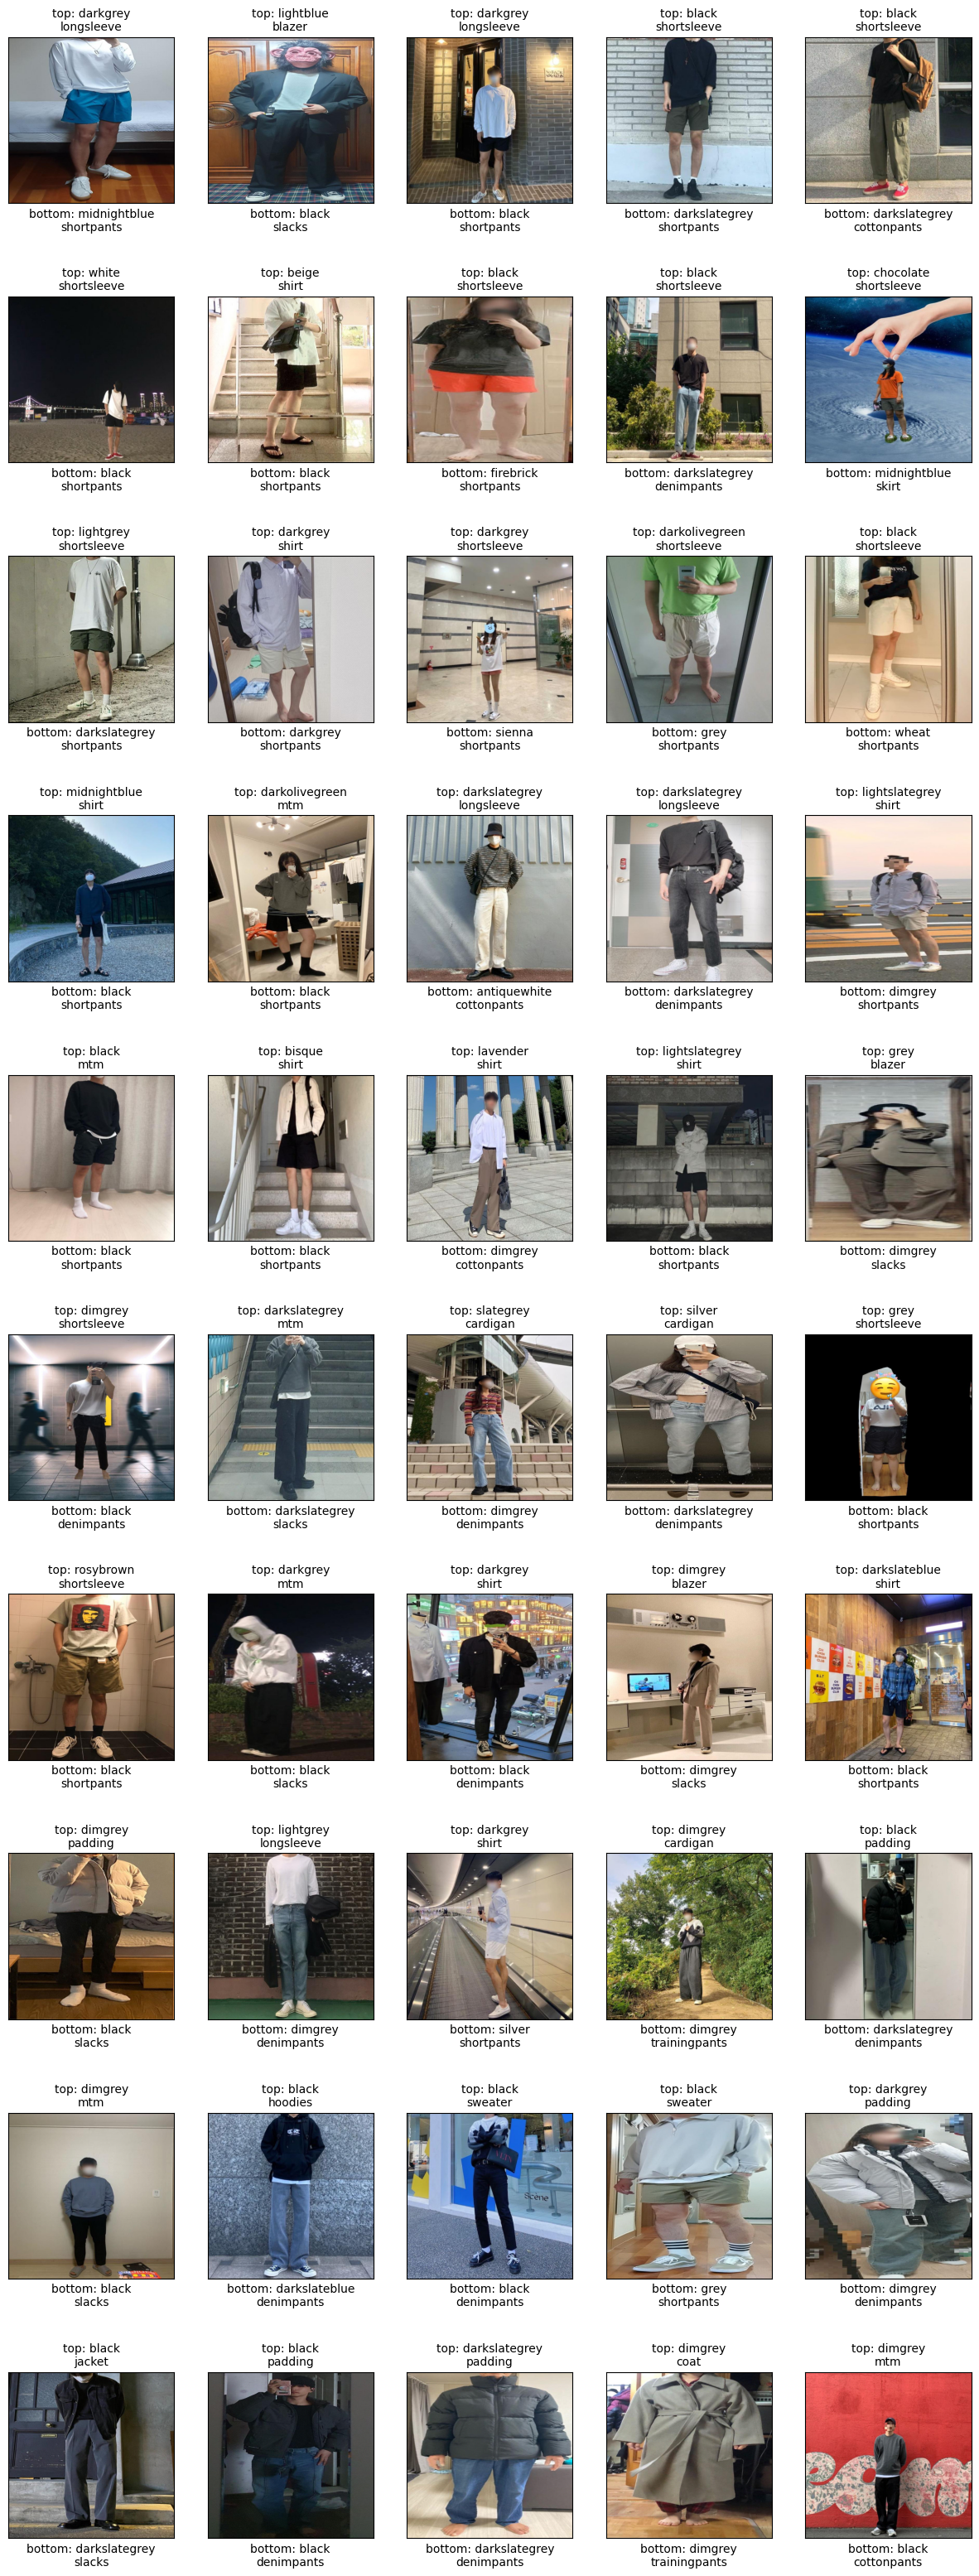

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# // %matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 40.0)



# struct is  [10, 5]
rows = 10
columns = 5

for i in range(len(result[:50])) : 
    image = Image.open(result['img_path'][i])
    image_index = i + 1     # image index 
    ttitle = f"top: {result['top_color'][i]}\n{result['top_category'][i]}" # image title
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(ttitle, fontsize=10)   # title 
    # // plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.xlabel(f"bottom: {result['bottom_color'][i]}\n{result['bottom_category'][i]}", fontsize=10)
    plt.imshow(image)

plt.show()

In [ ]:
# 어떤 카테고리 + 색감이 가장 많았는지
# 색감별로 보여주기
# 카테고리별 보여주기